In [322]:
#Backup of current work just in case of loss of power

In [1]:
import glob
import pandas as pd
import numpy as np
import swifter
from ast import literal_eval
from pandas_profiling import ProfileReport

In [ ]:
# Data from: https://webrobots.io/kickstarter-datasets/ * Used in current model
# Reads in all files in a directory(make sure that all files are csv)
files = glob.glob("data/Kickstarter_2021-01-14T03_20_05_328Z/*")
df = pd.concat(map(pd.read_csv, files), ignore_index=True)

In [ ]:
# Data from https://www.kaggle.com/sripaadsrinivasan/kickstarter-campaigns-dataset
df = pd.read_csv('data/kickstarter_data_full.csv', low_memory=False).drop(columns=['Unnamed: 0'])
columns = ['blurb', 'category', 'country', 'currency', 'goal', 'name', 'state']
df = df[columns].copy()

In [ ]:
# Profile report for data exploring
profile = ProfileReport(df, minimal=True)
profile.to_notebook_iframe()

In [ ]:
# Dropping unneeded colums
columns = ['friends', 'is_backing', 'is_starred', 'permissions', 'is_starrable', 'urls', 'creator', 'photo', 'profile', 'source_url', 'backers_count', 'converted_pledged_amount', 'created_at', 'location', 'deadline', 'currency_symbol', 'disable_communication', 'id', 'launched_at', 'pledged', 'slug', 'spotlight', 'staff_pick', 'state_changed_at', 'currency_trailing_code', 'fx_rate', 'current_currency', 'usd_pledged', 'static_usd_rate', 'country_displayable_name']
df = df.drop(columns=columns)

In [ ]:
# Changing the stringified dictionary to a dictionary and only returning id 'name'
# swifter allows faster .apply() method for pandas
df['category'] = df['category'].swifter.apply(lambda x: literal_eval(x)['name'])

In [ ]:
#Save current data to csv so no time is wasted recleaning data
df.to_csv('cleaned_dataset.csv', index=False)

In [300]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, TextVectorization, Input, concatenate, StringLookup, BatchNormalization, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

In [3]:
df = pd.read_csv('cleaned_dataset.csv').dropna()

In [4]:
# Filtering the dataset to make target column binary
df_binary = df.loc[(df['state']=='successful') | (df['state']=='failed')]

In [308]:
# Used for making the vocab for a layer
seq_len = 40
cat_feat = df_binary.drop(columns=['blurb', 'name', 'state', 'goal', 'usd_type'])
# Chaning from string to integer values
y = df_binary['state']
y = y.replace('successful', 1)
y = y.replace('failed', 0)

In [306]:
# Makeing vocab
vocab = set()
for cols in cat_feat.columns:
    for row in cat_feat[cols]:
        vocab.add(row)
vocab = list(vocab)

In [320]:
# Inputs
nlp_blurb = Input(shape=(1,), dtype=tf.string)
nlp_name = Input(shape=(1,), dtype=tf.string)
nlp_cols = Input(shape=(3,), dtype=tf.string)
meta_input = Input(1, dtype=tf.float32)

# Text vectorization and embedding for 'blurb' to save preprocessing time
text_vect_obj = TextVectorization(max_tokens=20000, output_sequence_length=40, pad_to_max_tokens=True)
text_vect_obj.adapt(df_binary['blurb'])
text_vect = text_vect_obj(nlp_blurb)
embed = Embedding(len(text_vect_obj.get_vocabulary()), 50)(text_vect)
nlp_blurb_out = Flatten()(embed)

# Text vectorization and embedding for 'name' to save preprocessing time
text_vect_obj2 = TextVectorization(max_tokens=20000, output_sequence_length=40, pad_to_max_tokens=True)
text_vect_obj2.adapt(df_binary['name'])
text_vect2 = text_vect_obj2(nlp_name)
embed_2 = Embedding(len(text_vect_obj.get_vocabulary()), 50)(text_vect2)
nlp_name_out = Flatten()(embed_2)

# Encoding the columns the columns that can be multi hot encoded
cat_encoding = StringLookup(output_mode='multi_hot', vocabulary=vocab)(nlp_cols)

# Normalizing 'goal' to save preprocessing time
norm = BatchNormalization()(meta_input)

# Concatinates the outputs for the nlp models, multi hot model and normilization model
num_cat = concatenate([nlp_blurb_out, nlp_name_out, cat_encoding, norm])

# Standard Dense model with max_norm constraints and Dropout for weight regularization
x = Dense(1000, activation='relu', kernel_constraint=max_norm(), bias_constraint=max_norm())(num_cat)
x = Dropout(0.3)(x)
x = Dense(750, activation='relu', kernel_constraint=max_norm(), bias_constraint=max_norm())(x)
x = Dropout(0.3)(x)
x = Dense(500, activation='relu', kernel_constraint=max_norm(), bias_constraint=max_norm())(x)
x = Dropout(0.3)(x)
x = Dense(250, activation='relu', kernel_constraint=max_norm(), bias_constraint=max_norm())(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

# Inputs need to have all of the inputs above in list format [input1, input2, ...]
model = Model(inputs=[nlp_blurb, nlp_name, meta_input, nlp_cols], outputs=x)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [321]:
# Input data is going to be in list format, not in single dataframe as shown here [df[col1], df[col2], ...]
# Input order matters
# Using validation split and Earlystopping
model.fit([df_binary['blurb'], df_binary['name'], df_binary['goal'], df_binary[['category', 'country', 'currency']]], y, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/50
5180/5180 [==============================] - 58s 11ms/step - loss: 0.4254 - accuracy: 0.7824 - val_loss: 0.3976 - val_accuracy: 0.7997
Epoch 2/50
5180/5180 [==============================] - 60s 12ms/step - loss: 0.3157 - accuracy: 0.8543 - val_loss: 0.4085 - val_accuracy: 0.8061
Epoch 3/50
5180/5180 [==============================] - 56s 11ms/step - loss: 0.1897 - accuracy: 0.9219 - val_loss: 0.4744 - val_accuracy: 0.8034
Epoch 4/50
5180/5180 [==============================] - 55s 11ms/step - loss: 0.0826 - accuracy: 0.9691 - val_loss: 0.7561 - val_accuracy: 0.8010


In [324]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


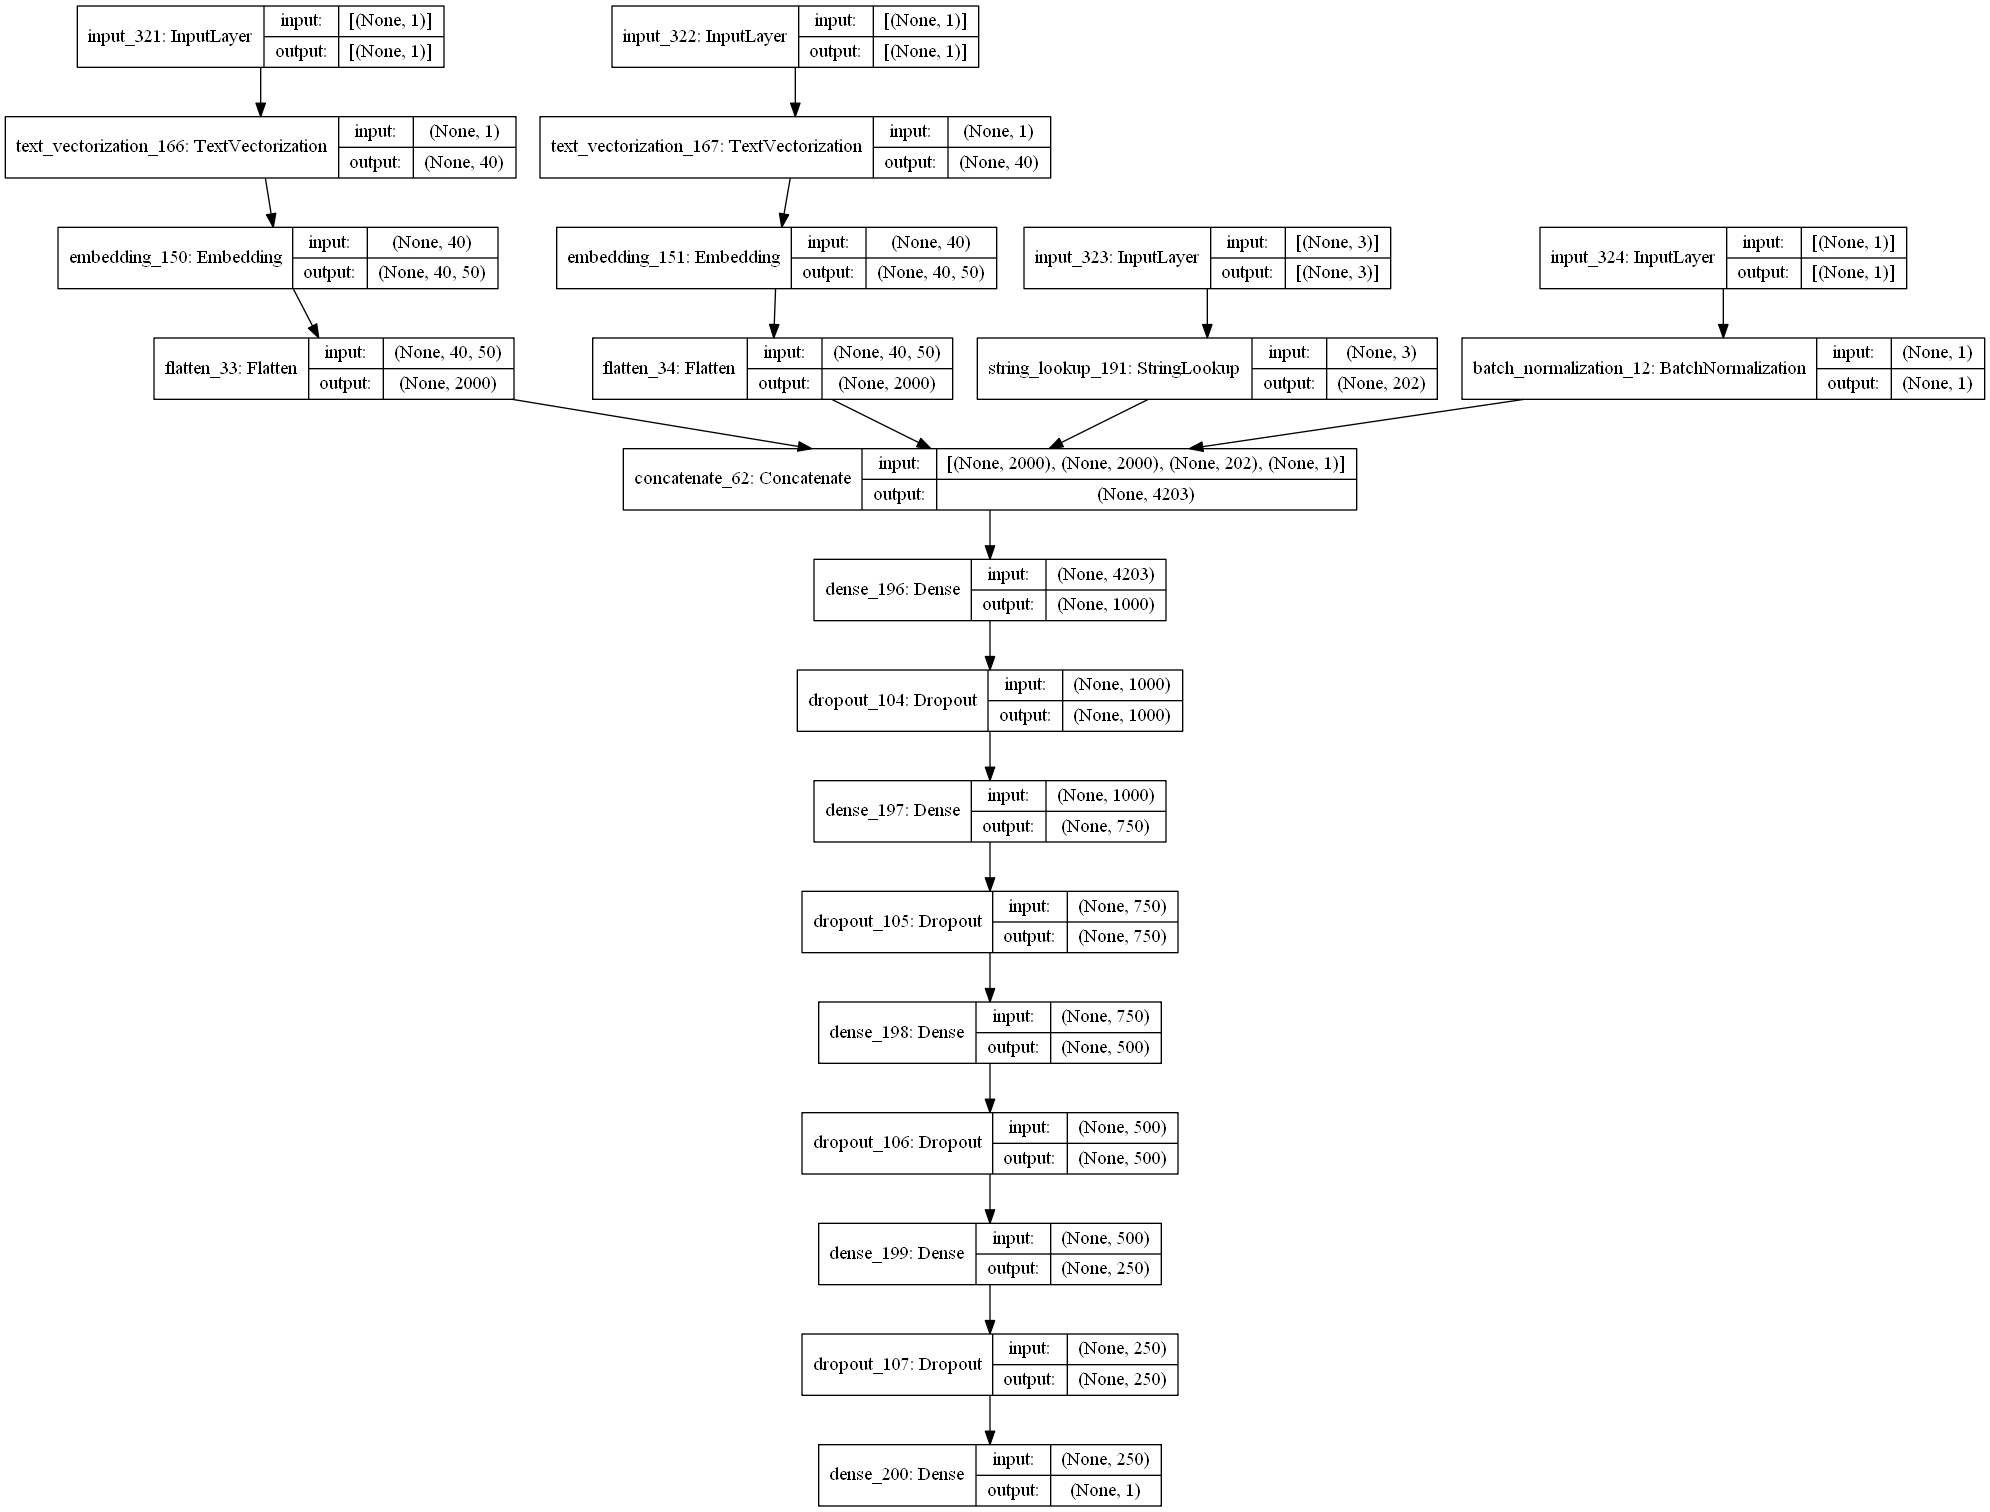

In [312]:
#Just a visualization of the model from above
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
#Next step is just grid search params for model, Most likey just Dense nodes and different weight regularization techniques and layers
#If time permits, optimizer and learning_rate